In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model

# Set plotting style
sns.set(style="whitegrid")

In [12]:
# Download daily data for Nasdaq (^IXIC)
nasdaq = yf.download("^IXIC", start="2018-01-01", end="2025-07-04")
nasdaq = nasdaq[["Close"]].dropna()
nasdaq.rename(columns={"Close": "price"}, inplace=True)

nasdaq.head()

C:\Users\B\AppData\Local\Temp\ipykernel_8328\1304768049.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nasdaq = yf.download("^IXIC", start="2018-01-01", end="2025-07-04")
[*********************100%***********************]  1 of 1 completed


Price,price
Ticker,^IXIC
Date,
2018-01-02,7006.899902
2018-01-03,7065.529785
2018-01-04,7077.910156
2018-01-05,7136.560059
2018-01-08,7157.390137


In [13]:
# Calculate daily log returns
nasdaq["returns"] = np.log(nasdaq["price"] / nasdaq["price"].shift(1))
nasdaq.dropna(inplace=True)

nasdaq.head()

Price,price,returns
Ticker,^IXIC,
Date,,
2018-01-03,7065.529785,0.008333
2018-01-04,7077.910156,0.001751
2018-01-05,7136.560059,0.008252
2018-01-08,7157.390137,0.002915
2018-01-09,7163.580078,0.000864


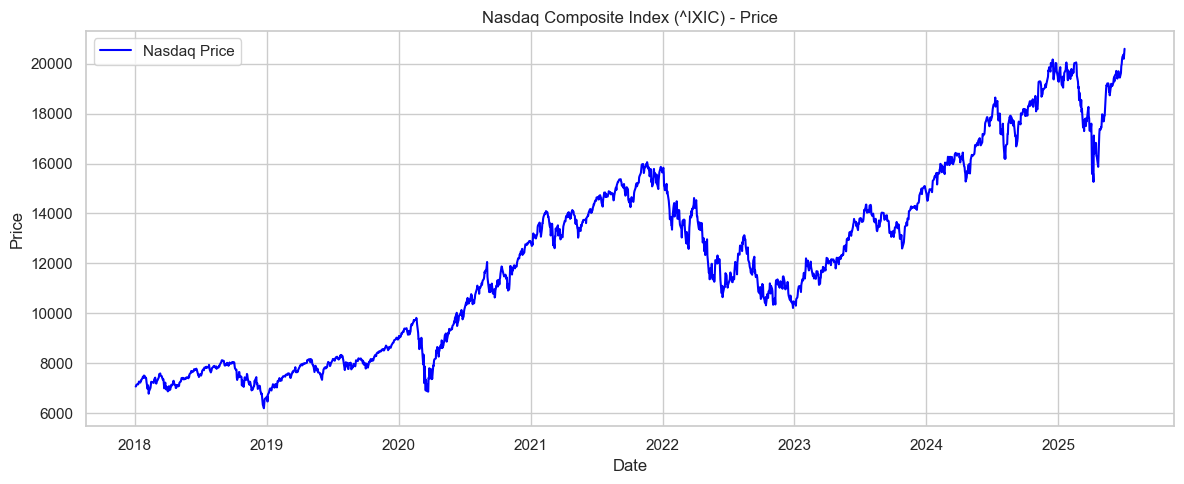

In [14]:
# Plot closing prices
plt.figure(figsize=(12, 5))
plt.plot(nasdaq.index, nasdaq["price"], color="blue", label="Nasdaq Price")
plt.title("Nasdaq Composite Index (^IXIC) - Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

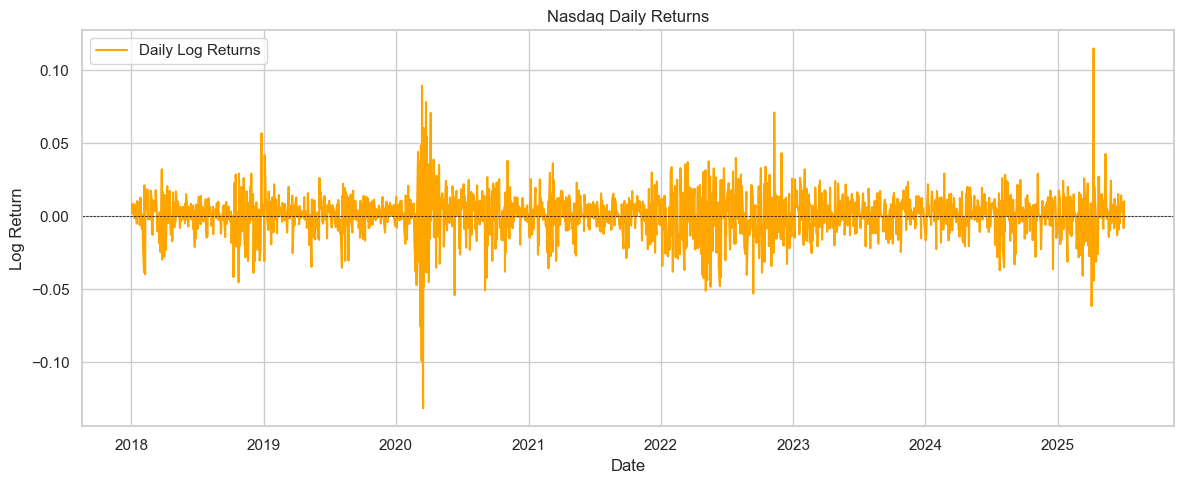

In [15]:
# Plot daily returns
plt.figure(figsize=(12, 5))
plt.plot(nasdaq.index, nasdaq["returns"], color="orange", label="Daily Log Returns")
plt.title("Nasdaq Daily Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Multiply by 100 — the arch package expects returns in percent
returns = nasdaq["returns"] * 100

In [17]:
# Define the model
model = arch_model(returns, vol="GARCH", p=1, q=1, mean="Zero", rescale=False)

# Fit the model
model_fit = model.fit(update_freq=5)

# Print the results summary
print(model_fit.summary())

Iteration:      5,   Func. Count:     29,   Neg. LLF: 3164.7630183774368
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3164.7627431864425
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3164.76
Distribution:                  Normal   AIC:                           6335.53
Method:            Maximum Likelihood   BIC:                           6352.15
                                        No. Observations:                 1885
Date:                Fri, Jul 04 2025   Df Residuals:                     1885
Time:                        17:09:00   Df Model:                            0
        

In [18]:
# Forecast 30 steps ahead
forecast_horizon = 30
forecast = model_fit.forecast(horizon=forecast_horizon)

# Extract the variance forecast (last row of the variance table)
variance_forecast = forecast.variance.iloc[-1]
volatility_forecast = np.sqrt(variance_forecast)

# Build a DataFrame for plotting
future_dates = pd.date_range(start=nasdaq.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq="B")
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Volatility": volatility_forecast.values
}).set_index("Date")

forecast_df.head()

,Volatility
Date,
2025-07-04,1.003818
2025-07-07,1.021050
2025-07-08,1.037633
2025-07-09,1.053604
2025-07-10,1.069000


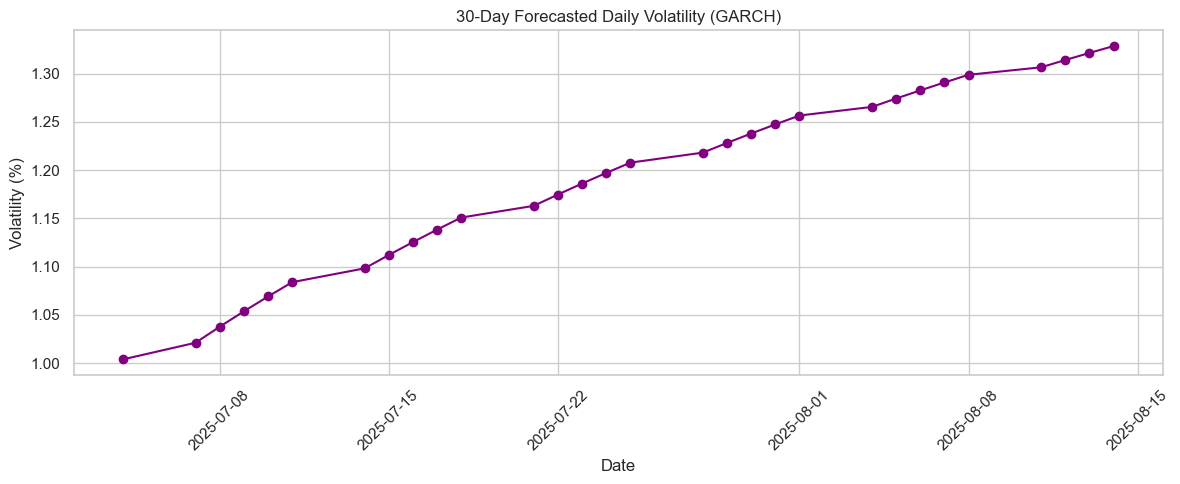

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(forecast_df.index, forecast_df["Volatility"], marker="o", color="purple")
plt.title("30-Day Forecasted Daily Volatility (GARCH)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

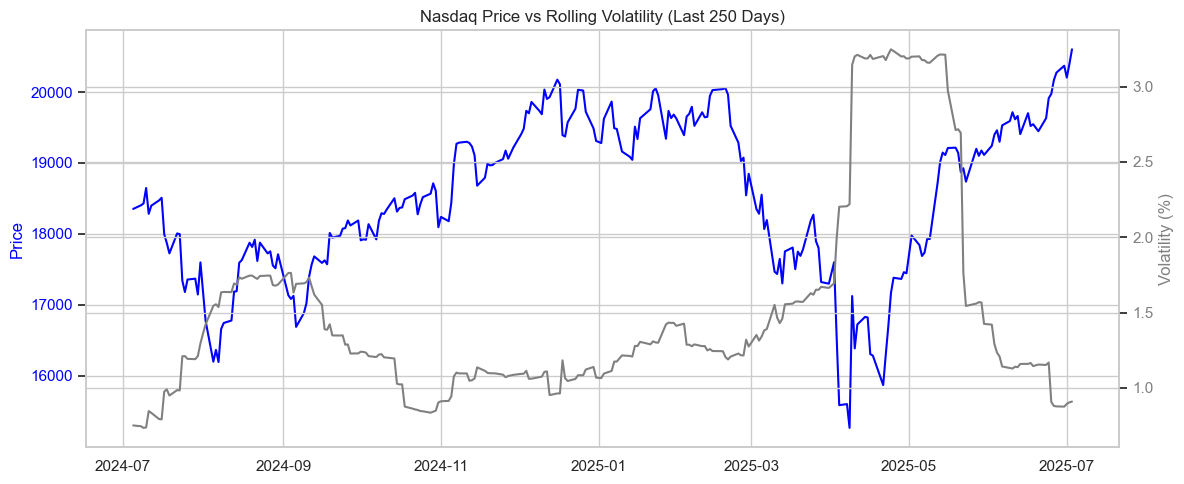

In [22]:
# Calculate 30-day rolling volatility
nasdaq["rolling_vol"] = nasdaq["returns"].rolling(window=30).std() * 100  # in percent

# Drop NA and match the last 250 rows for both series
recent_prices = nasdaq["price"].iloc[-250:]
recent_vol = nasdaq["rolling_vol"].dropna().iloc[-250:]

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Left y-axis: price
ax1.plot(recent_prices.index, recent_prices, color="blue", label="Price")
ax1.set_ylabel("Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Right y-axis: rolling volatility
ax2 = ax1.twinx()
ax2.plot(recent_vol.index, recent_vol, color="gray", label="30d Rolling Vol")
ax2.set_ylabel("Volatility (%)", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")

plt.title("Nasdaq Price vs Rolling Volatility (Last 250 Days)")
fig.tight_layout()
plt.show()

# Python Class: GARCHForecaster

In [25]:
class GARCHForecaster:
    def __init__(self, ticker, start="2018-01-01", end=None):
        self.ticker = ticker
        self.start = start
        self.end = end or pd.Timestamp.today().strftime("%Y-%m-%d")
        self.data = None
        self.model_fit = None
        self.forecast_df = None

    def download_data(self):
        df = yf.download(self.ticker, start=self.start, end=self.end, auto_adjust=True)[["Close"]].dropna()
        df.rename(columns={"Close": "price"}, inplace=True)
        df["returns"] = np.log(df["price"] / df["price"].shift(1))
        df.dropna(inplace=True)
        self.data = df
        return self.data

    def fit_model(self):
        returns = self.data["returns"] * 100
        model = arch_model(returns, vol="GARCH", p=1, q=1, mean="Zero", rescale=False)
        self.model_fit = model.fit(update_freq=5, disp="off")
        return self.model_fit

    def forecast_volatility(self, horizon=30):
        forecast = self.model_fit.forecast(horizon=horizon)
        variance_forecast = forecast.variance.iloc[-1]
        volatility_forecast = np.sqrt(variance_forecast)

        future_dates = pd.date_range(start=self.data.index[-1] + pd.Timedelta(days=1), periods=horizon, freq="B")
        self.forecast_df = pd.DataFrame({
            "Date": future_dates,
            "Volatility": volatility_forecast.values
        }).set_index("Date")

        return self.forecast_df

    def plot_forecast(self):
        if self.forecast_df is not None:
            plt.figure(figsize=(12, 5))
            plt.plot(self.forecast_df.index, self.forecast_df["Volatility"], marker="o", color="purple")
            plt.title(f"{self.ticker} - Forecasted Volatility (GARCH)")
            plt.xlabel("Date")
            plt.ylabel("Volatility (%)")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print("Please run forecast_volatility() first.")

# How to use the class:

[*********************100%***********************]  1 of 1 completed


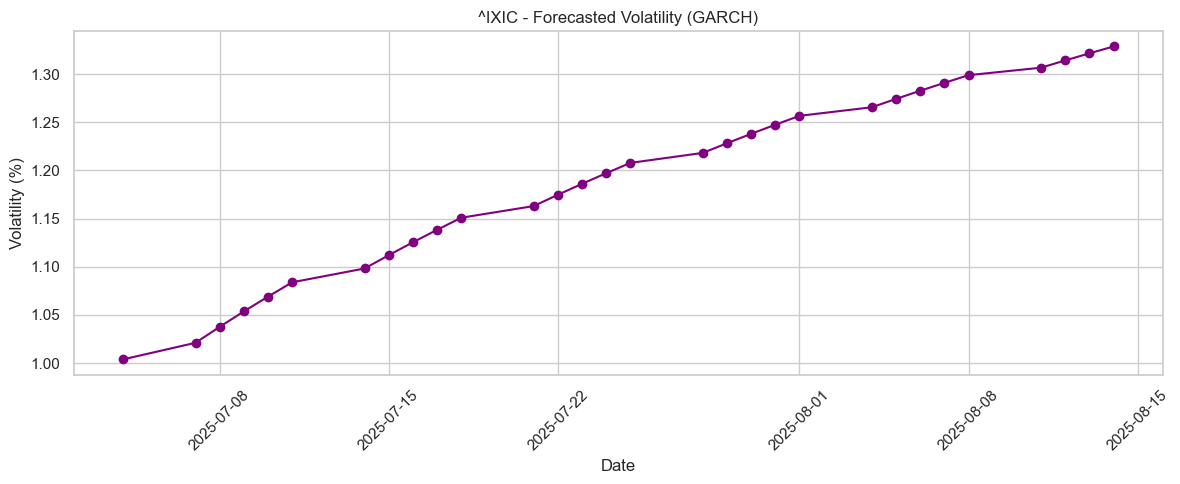

In [26]:
# Create instance
model = GARCHForecaster("^IXIC")

# Run steps
model.download_data()
model.fit_model()
model.forecast_volatility(horizon=30)
model.plot_forecast()

We’ll simulate many future price paths based on your GARCH volatility forecast. This gives you a realistic view of how Nasdaq might behave under modeled uncertainty.

In [37]:
def simulate_garch_paths(last_price, vol_forecast, n_paths=500, seed=42):
    np.random.seed(seed)
    n_days = len(vol_forecast)

    # Generate all random shocks (shape: n_days × n_paths)
    shocks = np.random.normal(
        loc=0,
        scale=np.tile(vol_forecast.values.reshape(-1, 1) / 100, n_paths)  # Convert % to decimal
    )

    # Calculate cumulative log returns
    log_price_paths = np.cumsum(shocks, axis=0)

    # Convert to price paths
    price_paths = last_price.item() * np.exp(log_price_paths)

    return price_paths

In [38]:
sim_paths = simulate_garch_paths(last_price, forecast_df["Volatility"], n_paths=500)

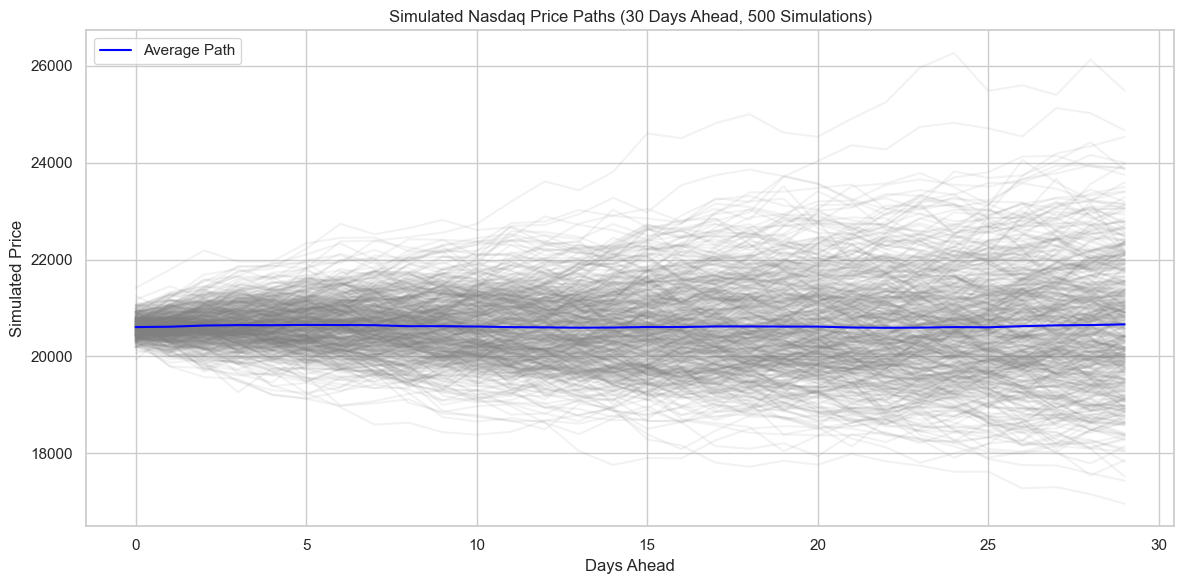

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(sim_paths, color="gray", alpha=0.1)
plt.plot(sim_paths.mean(axis=1), color="blue", label="Average Path")
plt.title("Simulated Nasdaq Price Paths (30 Days Ahead, 500 Simulations)")
plt.xlabel("Days Ahead")
plt.ylabel("Simulated Price")
plt.legend()
plt.tight_layout()
plt.show()

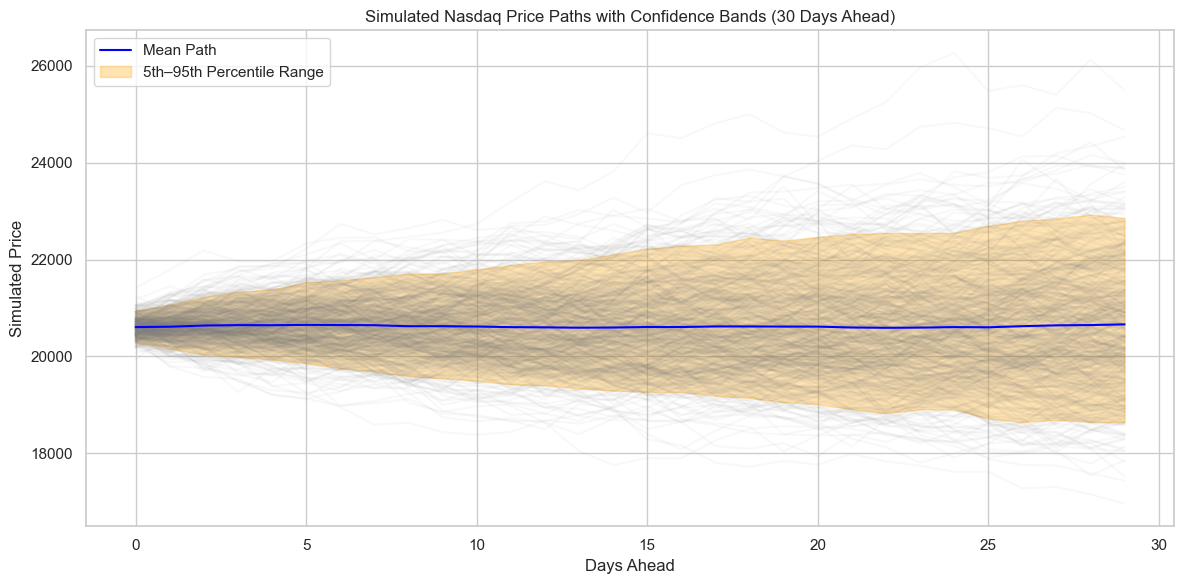

In [40]:
# Compute percentiles across simulations for each day
lower_bound = np.percentile(sim_paths, 5, axis=1)
upper_bound = np.percentile(sim_paths, 95, axis=1)
mean_path = sim_paths.mean(axis=1)

# Plot with confidence bands
plt.figure(figsize=(12, 6))
plt.plot(sim_paths, color="gray", alpha=0.05)  # all paths
plt.plot(mean_path, color="blue", label="Mean Path")
plt.fill_between(range(len(mean_path)), lower_bound, upper_bound, color="orange", alpha=0.3, label="5th–95th Percentile Range")
plt.title("Simulated Nasdaq Price Paths with Confidence Bands (30 Days Ahead)")
plt.xlabel("Days Ahead")
plt.ylabel("Simulated Price")
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
actual_prices = nasdaq["price"].iloc[-30:].reset_index(drop=True)

In [48]:
signals = []

for i in range(30):
    price = actual_prices.iloc[i].item()
    lb = lower_bound[i].item()
    ub = upper_bound[i].item()

    if price < lb:
        signals.append("Buy")
    elif price > ub:
        signals.append("Sell")
    else:
        signals.append("Hold")

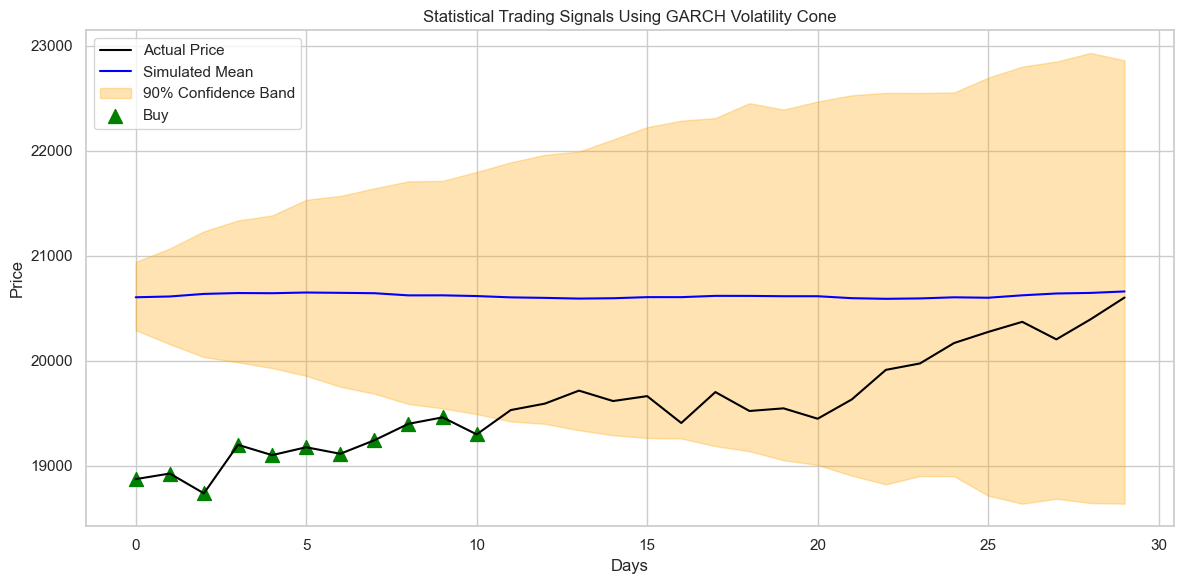

In [49]:
plt.figure(figsize=(12, 6))

# Actual prices
plt.plot(actual_prices.values, label="Actual Price", color="black")

# Simulated average path
plt.plot(mean_path, label="Simulated Mean", color="blue")

# Confidence bands
plt.fill_between(range(30), lower_bound, upper_bound, color="orange", alpha=0.3, label="90% Confidence Band")

# Mark signals
for i, signal in enumerate(signals):
    if signal == "Buy":
        plt.scatter(i, actual_prices.iloc[i], color="green", marker="^", s=100, label="Buy" if i == 0 else "")
    elif signal == "Sell":
        plt.scatter(i, actual_prices.iloc[i], color="red", marker="v", s=100, label="Sell" if i == 0 else "")

plt.title("Statistical Trading Signals Using GARCH Volatility Cone")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()